In [73]:
# Configuración para reproducibilidad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.datasets as datasets


np.random.seed(42)
torch.manual_seed(42)



In [74]:
# Cargar el dataset CIFAR-100
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=None)

# Extraer datos y etiquetas
X_train = np.array([np.array(x) for x, _ in trainset])
y_train = np.array([y for _, y in trainset]).reshape(-1, 1)
X_test = np.array([np.array(x) for x, _ in testset])
y_test = np.array([y for _, y in testset]).reshape(-1, 1)

print("Forma de los datos de entrenamiento:", X_train.shape)
print("Forma de las etiquetas de entrenamiento:", y_train.shape)
print("Forma de los datos de prueba:", X_test.shape)
print("Forma de las etiquetas de prueba:", y_test.shape)

Forma de los datos de entrenamiento: (50000, 32, 32, 3)
Forma de las etiquetas de entrenamiento: (50000, 1)
Forma de los datos de prueba: (10000, 32, 32, 3)
Forma de las etiquetas de prueba: (10000, 1)


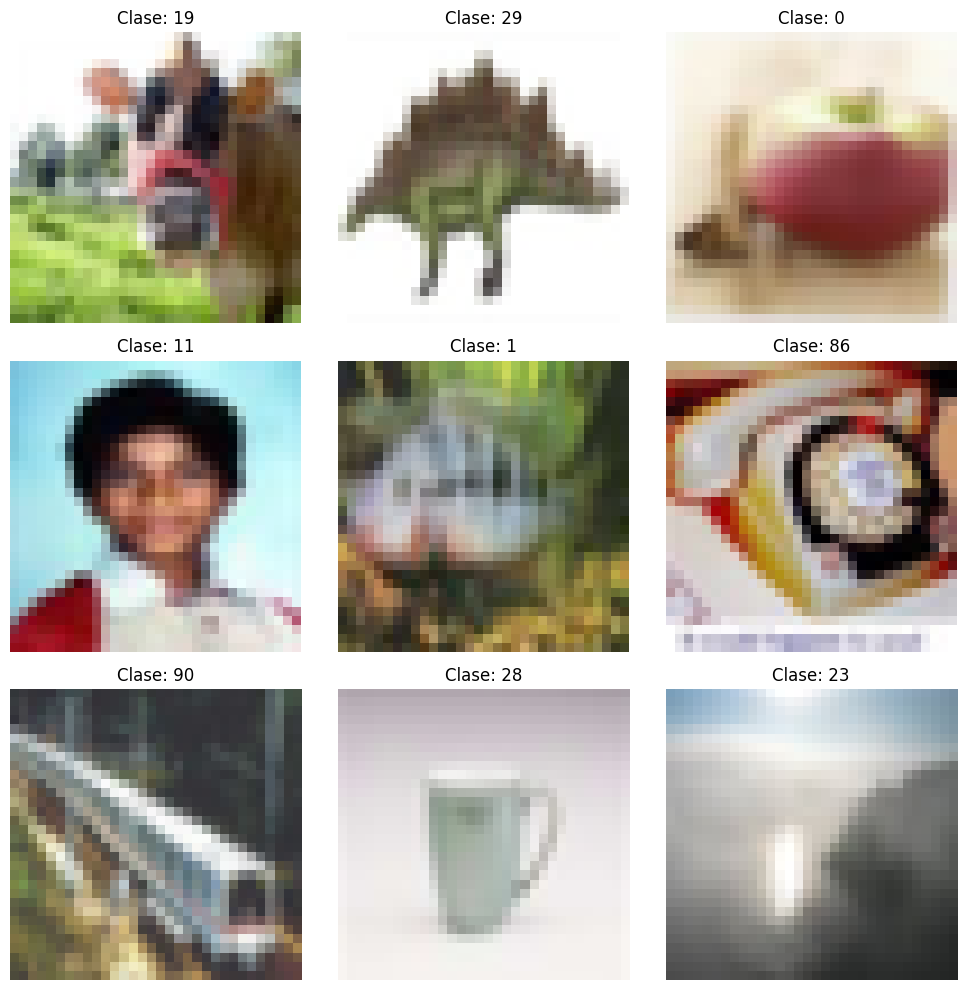

In [75]:
# Visualizar algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Clase: {y_train[i][0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_376\580960327.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train.flatten(), palette='viridis')


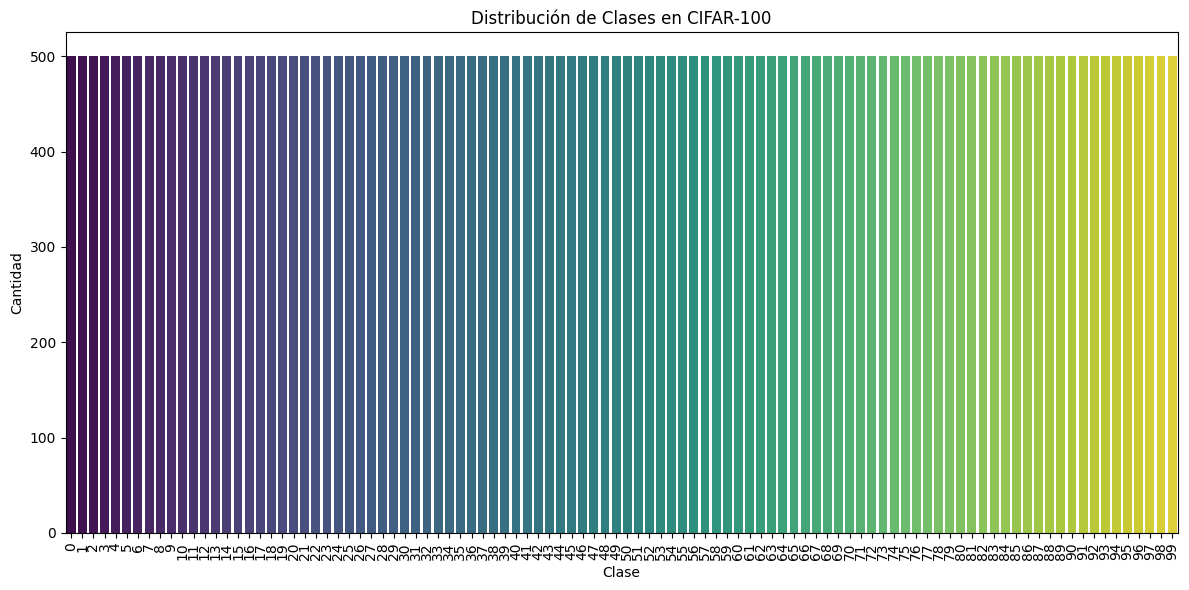

In [76]:
# Análisis de la distribución de clases
plt.figure(figsize=(12, 6))
sns.countplot(x=y_train.flatten(), palette='viridis')
plt.title('Distribución de Clases en CIFAR-100')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [77]:
# Preprocesamiento de datos
# Normalización manual de los datos de imagen (dividiendo por 255)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape manual en lugar de usar Flatten
# Las imágenes son de 32x32x3, las convertimos a vectores de 32*32*3 = 3072 elementos
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

print("Forma de los datos reshapeados de entrenamiento:", X_train_reshaped.shape)
print("Forma de los datos reshapeados de prueba:", X_test_reshaped.shape)

# One-hot encoding para las etiquetas
num_classes = 100
# En PyTorch no necesitamos one-hot encoding para CrossEntropyLoss
# Pero lo mantenemos para consistencia con el código original
y_train_encoded = np.zeros((y_train.size, num_classes))
y_train_encoded[np.arange(y_train.size), y_train.flatten()] = 1
y_test_encoded = np.zeros((y_test.size, num_classes))
y_test_encoded[np.arange(y_test.size), y_test.flatten()] = 1

print("Forma de las etiquetas codificadas de entrenamiento:", y_train_encoded.shape)
print("Forma de las etiquetas codificadas de prueba:", y_test_encoded.shape)


Forma de los datos reshapeados de entrenamiento: (50000, 3072)
Forma de los datos reshapeados de prueba: (10000, 3072)
Forma de las etiquetas codificadas de entrenamiento: (50000, 100)
Forma de las etiquetas codificadas de prueba: (10000, 100)


In [78]:
class MLPModel(nn.Module):
    """
    Crea un modelo MLP con las capas especificadas.
    
    Args:
        input_shape: Forma de los datos de entrada
        num_classes: Número de clases para la capa de salida
        activation: Función de activación para las capas ocultas
        dropout_rate: Tasa de dropout
        use_batch_norm: Si se debe usar normalización por lotes
    
    Returns:
        Modelo compilado
    """
    def __init__(self, input_shape, num_classes, activation='relu', dropout_rate=0.2, use_batch_norm=True):
        super(MLPModel, self).__init__()
        
        # Primera capa oculta
        self.fc1 = nn.Linear(input_shape[0], 1024)
        self.bn1 = nn.BatchNorm1d(1024) if use_batch_norm else None
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Segunda capa oculta
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512) if use_batch_norm else None
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Tercera capa oculta
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256) if use_batch_norm else None
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Capa de salida
        self.fc4 = nn.Linear(256, num_classes)
        
        # Definir la función de activación
        self.activation = nn.ReLU() if activation == 'relu' else nn.ReLU()
        self.use_batch_norm = use_batch_norm
    
    def forward(self, x):
        # Primera capa oculta
        x = self.fc1(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.dropout1(x)
        
        # Segunda capa oculta
        x = self.fc2(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.dropout2(x)
        
        # Tercera capa oculta
        x = self.fc3(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = self.dropout3(x)
        
        # Capa de salida
        x = self.fc4(x)
        return x

# Crear modelo base
input_shape = X_train_reshaped.shape[1:]
modelo_base = MLPModel(input_shape, num_classes)

# Resumen del modelo
print(modelo_base)



MLPModel(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=256, out_features=100, bias=True)
  (activation): ReLU()
)


In [79]:
# Convertir datos a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_reshaped)
y_train_tensor = torch.LongTensor(y_train.flatten())
X_test_tensor = torch.FloatTensor(X_test_reshaped)
y_test_tensor = torch.LongTensor(y_test.flatten())

In [80]:
# Entrenamiento del modelo base
batch_size = 256  # Según lo especificado
epochs = 50

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_base.parameters(), lr=0.001)

In [81]:
# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [82]:
# Verificar si hay GPU disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelo_base.to(device)


MLPModel(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=256, out_features=100, bias=True)
  (activation): ReLU()
)

In [83]:
# Callback para detener el entrenamiento si no hay mejora
patience = 60
best_val_loss = float('inf')
counter = 0

# Entrenamiento
history_base = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(epochs):
    # Modo entrenamiento
    modelo_base.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Poner a cero los gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = modelo_base(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_dataset)
    train_acc = 100 * correct / total
    history_base['loss'].append(train_loss)
    history_base['accuracy'].append(train_acc)
    
    # Modo evaluación
    modelo_base.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo_base(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_dataset)
    val_acc = 100 * correct / total
    history_base['val_loss'].append(val_loss)
    history_base['val_accuracy'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Guardar el mejor modelo
        torch.save(modelo_base.state_dict(), 'c:\\Users\\PC\\Desktop\\prueba\\best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping después de {epoch+1} épocas')
            break


Epoch 1/50, Loss: 3.9627, Accuracy: 9.68%, Val Loss: 3.6588, Val Accuracy: 14.42%
Epoch 2/50, Loss: 3.5852, Accuracy: 15.32%, Val Loss: 3.4959, Val Accuracy: 17.56%
Epoch 3/50, Loss: 3.4301, Accuracy: 17.98%, Val Loss: 3.3686, Val Accuracy: 20.46%
Epoch 4/50, Loss: 3.3295, Accuracy: 19.90%, Val Loss: 3.3100, Val Accuracy: 21.30%
Epoch 5/50, Loss: 3.2627, Accuracy: 20.87%, Val Loss: 3.3242, Val Accuracy: 20.63%
Epoch 6/50, Loss: 3.2036, Accuracy: 22.02%, Val Loss: 3.2494, Val Accuracy: 22.00%
Epoch 7/50, Loss: 3.1477, Accuracy: 22.89%, Val Loss: 3.2636, Val Accuracy: 22.28%
Epoch 8/50, Loss: 3.1014, Accuracy: 23.68%, Val Loss: 3.2391, Val Accuracy: 21.83%
Epoch 9/50, Loss: 3.0513, Accuracy: 24.69%, Val Loss: 3.1534, Val Accuracy: 23.74%
Epoch 10/50, Loss: 3.0032, Accuracy: 25.26%, Val Loss: 3.1877, Val Accuracy: 23.68%
Epoch 11/50, Loss: 2.9730, Accuracy: 25.95%, Val Loss: 3.1253, Val Accuracy: 24.50%
Epoch 12/50, Loss: 2.9337, Accuracy: 26.70%, Val Loss: 3.1305, Val Accuracy: 23.89%
Ep

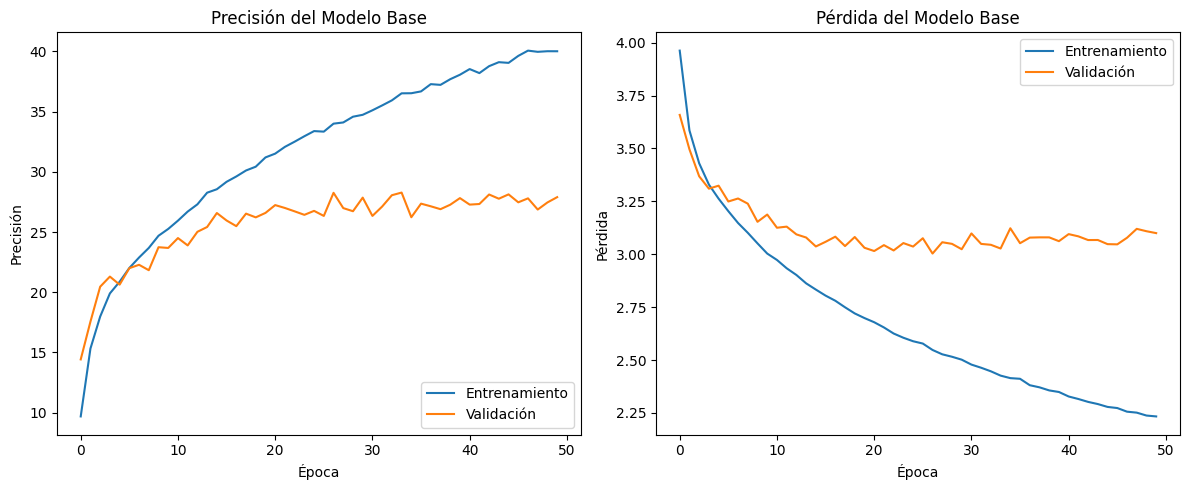

In [84]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_base['accuracy'])
plt.plot(history_base['val_accuracy'])
plt.title('Precisión del Modelo Base')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_base['loss'])
plt.plot(history_base['val_loss'])
plt.title('Pérdida del Modelo Base')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.tight_layout()
plt.show()


Métricas del Modelo Base:
Accuracy: 0.2761
Precision: 0.2861
Recall: 0.2761
F1-Score: 0.2727


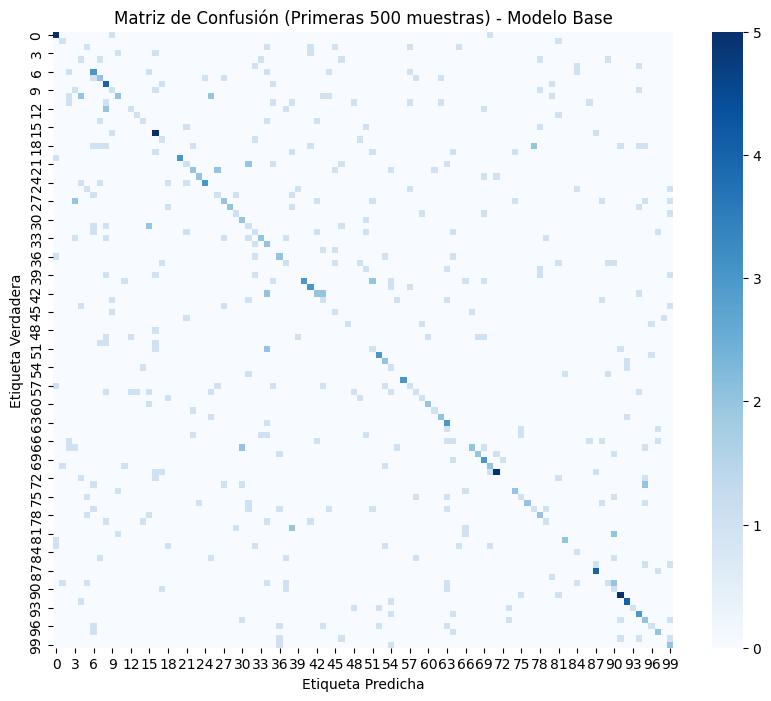


Informe de Clasificación - Modelo Base (primeras 10 clases):
              precision    recall  f1-score   support

     Clase 0       0.42      0.54      0.47       100
     Clase 1       0.32      0.38      0.35       100
     Clase 2       0.19      0.20      0.19       100
     Clase 3       0.13      0.19      0.15       100
     Clase 4       0.08      0.10      0.09       100
     Clase 5       0.20      0.24      0.22       100
     Clase 6       0.17      0.24      0.20       100
     Clase 7       0.32      0.22      0.26       100
     Clase 8       0.23      0.38      0.29       100
     Clase 9       0.39      0.34      0.36       100

   micro avg       0.24      0.28      0.26      1000
   macro avg       0.25      0.28      0.26      1000
weighted avg       0.25      0.28      0.26      1000



In [85]:
# 3. Evaluación del Modelo Base
# -----------------------------

# Predicciones
modelo_base.eval()  # Poner el modelo en modo evaluación
with torch.no_grad():
    outputs = modelo_base(X_test_tensor.to(device))
    _, y_pred_base = torch.max(outputs, 1)
    y_pred_base = y_pred_base.cpu().numpy()  # Convertir a numpy array

y_test_original = y_test.flatten()

# Métricas de evaluación
accuracy_base = accuracy_score(y_test_original, y_pred_base)
precision_base = precision_score(y_test_original, y_pred_base, average='weighted')
recall_base = recall_score(y_test_original, y_pred_base, average='weighted')
f1_base = f1_score(y_test_original, y_pred_base, average='weighted')

print("\nMétricas del Modelo Base:")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"Precision: {precision_base:.4f}")
print(f"Recall: {recall_base:.4f}")
print(f"F1-Score: {f1_base:.4f}")

# Matriz de confusión (mostramos solo una parte debido a las 100 clases)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_original[:500], y_pred_base[:500])  # Limitamos a 500 muestras para visualización
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Matriz de Confusión (Primeras 500 muestras) - Modelo Base')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("\nInforme de Clasificación - Modelo Base (primeras 10 clases):")
print(classification_report(y_test_original, y_pred_base, labels=range(10), target_names=[f"Clase {i}" for i in range(10)]))


Entrenando modelo con activación: relu
Epoch 1/50, Loss: 3.9585, Accuracy: 9.86%, Val Loss: 3.7188, Val Accuracy: 14.28%
Epoch 2/50, Loss: 3.5772, Accuracy: 15.43%, Val Loss: 3.4666, Val Accuracy: 18.56%
Epoch 3/50, Loss: 3.4271, Accuracy: 18.17%, Val Loss: 3.3635, Val Accuracy: 19.43%
Epoch 4/50, Loss: 3.3185, Accuracy: 19.87%, Val Loss: 3.4792, Val Accuracy: 18.59%
Epoch 5/50, Loss: 3.2433, Accuracy: 21.06%, Val Loss: 3.2975, Val Accuracy: 20.82%
Epoch 6/50, Loss: 3.1810, Accuracy: 22.23%, Val Loss: 3.1826, Val Accuracy: 22.63%
Epoch 7/50, Loss: 3.1292, Accuracy: 23.16%, Val Loss: 3.2739, Val Accuracy: 21.97%
Epoch 8/50, Loss: 3.0795, Accuracy: 24.17%, Val Loss: 3.1421, Val Accuracy: 23.93%
Epoch 9/50, Loss: 3.0416, Accuracy: 24.86%, Val Loss: 3.1615, Val Accuracy: 24.03%
Epoch 10/50, Loss: 3.0057, Accuracy: 25.39%, Val Loss: 3.1104, Val Accuracy: 24.85%
Epoch 11/50, Loss: 2.9704, Accuracy: 26.11%, Val Loss: 3.0956, Val Accuracy: 25.22%
Epoch 12/50, Loss: 2.9529, Accuracy: 26.44%, V

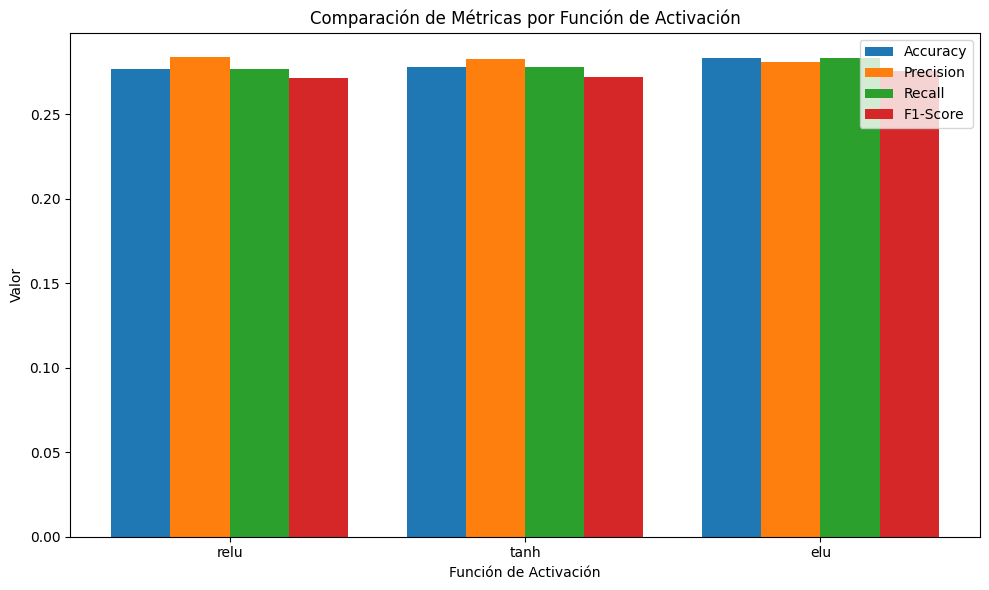

In [86]:
# Experimento 1: Diferentes funciones de activación
activaciones = ['relu', 'tanh', 'elu']
resultados_activacion = []

for activacion in activaciones:
    print(f"\nEntrenando modelo con activación: {activacion}")
    
    # Crear modelo con la activación especificada
    modelo = MLPModel(input_shape, num_classes, activation=activacion)
    modelo.to(device)
    
    # Definir función de pérdida y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelo.parameters(), lr=0.001)
    
    # Early stopping
    patience = 60
    best_val_loss = float('inf')
    counter = 0
    
    # Historial para guardar métricas
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    # Entrenamiento por 50 épocas (reducido para experimentación)
    for epoch in range(50):
        # Modo entrenamiento
        modelo.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Poner a cero los gradientes
            optimizer.zero_grad()
            
            # Forward pass
            outputs = modelo(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass y optimización
            loss.backward()
            optimizer.step()
            
            # Estadísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_dataset)
        train_acc = 100 * correct / total
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        
        # Modo evaluación
        modelo.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = modelo(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = running_loss / len(val_dataset)
        val_acc = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch {epoch+1}/50, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping después de {epoch+1} épocas')
                break
    
    # Evaluación en el conjunto de prueba
    modelo.eval()
    all_preds = []
    
    with torch.no_grad():
        for inputs in DataLoader(X_test_tensor, batch_size=batch_size):
            inputs = inputs.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
    
    # Métricas
    y_test_original = y_test.flatten()
    accuracy = accuracy_score(y_test_original, all_preds)
    precision = precision_score(y_test_original, all_preds, average='weighted')
    recall = recall_score(y_test_original, all_preds, average='weighted')
    f1 = f1_score(y_test_original, all_preds, average='weighted')
    
    resultados_activacion.append({
        'Activación': activacion,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Val_Loss_Final': min(history['val_loss']),
        'Épocas': len(history['loss'])
    })

# Tabla comparativa de activaciones
df_activacion = pd.DataFrame(resultados_activacion)
print("\nComparación de Funciones de Activación:")
print(df_activacion)

# Visualización de resultados de activación
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(activaciones))

plt.bar(index, df_activacion['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, df_activacion['Precision'], bar_width, label='Precision')
plt.bar(index + 2*bar_width, df_activacion['Recall'], bar_width, label='Recall')
plt.bar(index + 3*bar_width, df_activacion['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Función de Activación')
plt.ylabel('Valor')
plt.title('Comparación de Métricas por Función de Activación')
plt.xticks(index + 1.5*bar_width, activaciones)
plt.legend()
plt.tight_layout()
plt.show()


Entrenando modelo con tasa de dropout: 0.1
Epoch 1/50, Loss: 3.8956, Accuracy: 10.99%, Val Loss: 3.6896, Val Accuracy: 13.71%
Epoch 2/50, Loss: 3.5065, Accuracy: 16.96%, Val Loss: 3.5555, Val Accuracy: 16.36%
Epoch 3/50, Loss: 3.3393, Accuracy: 19.70%, Val Loss: 3.3917, Val Accuracy: 19.55%
Epoch 4/50, Loss: 3.2216, Accuracy: 21.74%, Val Loss: 3.3245, Val Accuracy: 20.53%
Epoch 5/50, Loss: 3.1295, Accuracy: 23.40%, Val Loss: 3.4324, Val Accuracy: 18.92%
Epoch 6/50, Loss: 3.0467, Accuracy: 24.98%, Val Loss: 3.2175, Val Accuracy: 22.56%
Epoch 7/50, Loss: 2.9739, Accuracy: 26.11%, Val Loss: 3.3288, Val Accuracy: 21.53%
Epoch 8/50, Loss: 2.9136, Accuracy: 27.08%, Val Loss: 3.1282, Val Accuracy: 24.76%
Epoch 9/50, Loss: 2.8428, Accuracy: 28.66%, Val Loss: 3.1534, Val Accuracy: 24.20%
Epoch 10/50, Loss: 2.7765, Accuracy: 29.79%, Val Loss: 3.2639, Val Accuracy: 23.07%
Epoch 11/50, Loss: 2.7272, Accuracy: 30.73%, Val Loss: 3.2078, Val Accuracy: 23.62%
Epoch 12/50, Loss: 2.6561, Accuracy: 32.0

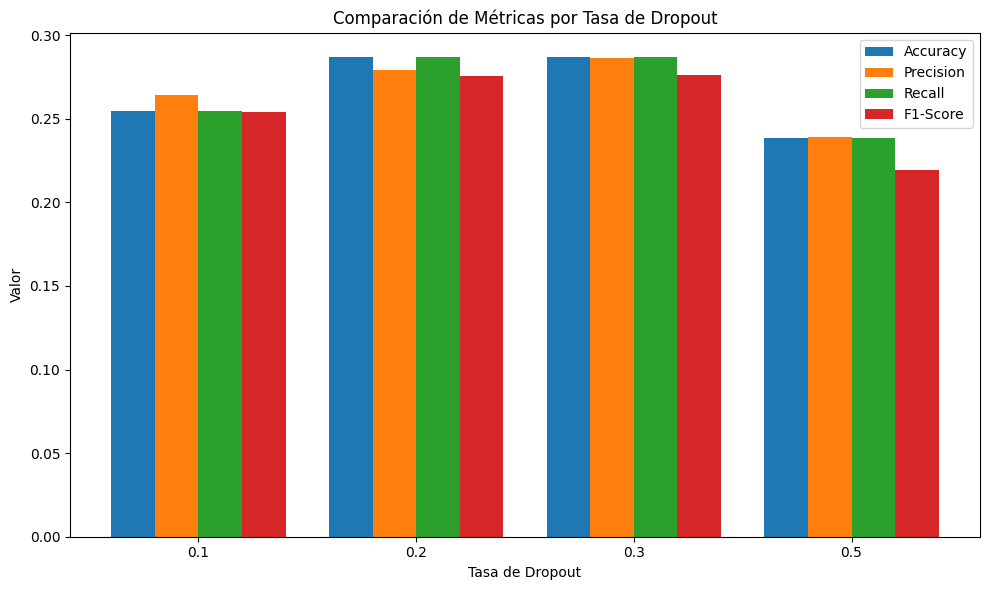

In [87]:
# Experimento 2: Diferentes tasas de Dropout
tasas_dropout = [0.1, 0.2, 0.3, 0.5]
resultados_dropout = []

for tasa in tasas_dropout:
    print(f"\nEntrenando modelo con tasa de dropout: {tasa}")
    
    # Crear modelo con la tasa de dropout especificada
    modelo = MLPModel(input_shape, num_classes, dropout_rate=tasa)
    modelo.to(device)
    
    # Definir función de pérdida y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelo.parameters(), lr=0.001)
    
    # Early stopping
    patience = 60
    best_val_loss = float('inf')
    counter = 0
    
    # Historial para guardar métricas
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    # Entrenamiento por 50 épocas (reducido para experimentación)
    for epoch in range(50):
        # Modo entrenamiento
        modelo.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Poner a cero los gradientes
            optimizer.zero_grad()
            
            # Forward pass
            outputs = modelo(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass y optimización
            loss.backward()
            optimizer.step()
            
            # Estadísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_dataset)
        train_acc = 100 * correct / total
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        
        # Modo evaluación
        modelo.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = modelo(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = running_loss / len(val_dataset)
        val_acc = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch {epoch+1}/50, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping después de {epoch+1} épocas')
                break
    
    # Evaluación en el conjunto de prueba
    modelo.eval()
    all_preds = []
    
    with torch.no_grad():
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
    
    # Métricas
    y_test_original = y_test.flatten()
    accuracy = accuracy_score(y_test_original, all_preds)
    precision = precision_score(y_test_original, all_preds, average='weighted')
    recall = recall_score(y_test_original, all_preds, average='weighted')
    f1 = f1_score(y_test_original, all_preds, average='weighted')
    
    resultados_dropout.append({
        'Tasa_Dropout': tasa,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Val_Loss_Final': min(history['val_loss']),
        'Épocas': len(history['loss'])
    })

# Tabla comparativa de tasas de dropout
df_dropout = pd.DataFrame(resultados_dropout)
print("\nComparación de Tasas de Dropout:")
print(df_dropout)

# Visualización de resultados de dropout
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(tasas_dropout))

plt.bar(index, df_dropout['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, df_dropout['Precision'], bar_width, label='Precision')
plt.bar(index + 2*bar_width, df_dropout['Recall'], bar_width, label='Recall')
plt.bar(index + 3*bar_width, df_dropout['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Tasa de Dropout')
plt.ylabel('Valor')
plt.title('Comparación de Métricas por Tasa de Dropout')
plt.xticks(index + 1.5*bar_width, [str(tasa) for tasa in tasas_dropout])
plt.legend()
plt.tight_layout()
plt.show()


Entrenando modelo Con BN
Epoch 1/50, Loss: 3.9442, Accuracy: 10.16%, Val Loss: 3.6285, Val Accuracy: 15.14%
Epoch 2/50, Loss: 3.5715, Accuracy: 15.74%, Val Loss: 3.4969, Val Accuracy: 16.86%
Epoch 3/50, Loss: 3.4223, Accuracy: 18.21%, Val Loss: 3.4688, Val Accuracy: 18.77%
Epoch 4/50, Loss: 3.3275, Accuracy: 20.14%, Val Loss: 3.3009, Val Accuracy: 20.78%
Epoch 5/50, Loss: 3.2457, Accuracy: 21.11%, Val Loss: 3.3910, Val Accuracy: 19.62%
Epoch 6/50, Loss: 3.1899, Accuracy: 22.14%, Val Loss: 3.3154, Val Accuracy: 20.71%
Epoch 7/50, Loss: 3.1405, Accuracy: 22.88%, Val Loss: 3.2760, Val Accuracy: 21.10%
Epoch 8/50, Loss: 3.0866, Accuracy: 23.91%, Val Loss: 3.1900, Val Accuracy: 23.17%
Epoch 9/50, Loss: 3.0477, Accuracy: 24.79%, Val Loss: 3.4354, Val Accuracy: 23.65%
Epoch 10/50, Loss: 3.0124, Accuracy: 25.22%, Val Loss: 3.1293, Val Accuracy: 24.27%
Epoch 11/50, Loss: 2.9647, Accuracy: 26.02%, Val Loss: 3.1598, Val Accuracy: 23.74%
Epoch 12/50, Loss: 2.9363, Accuracy: 26.61%, Val Loss: 3.13

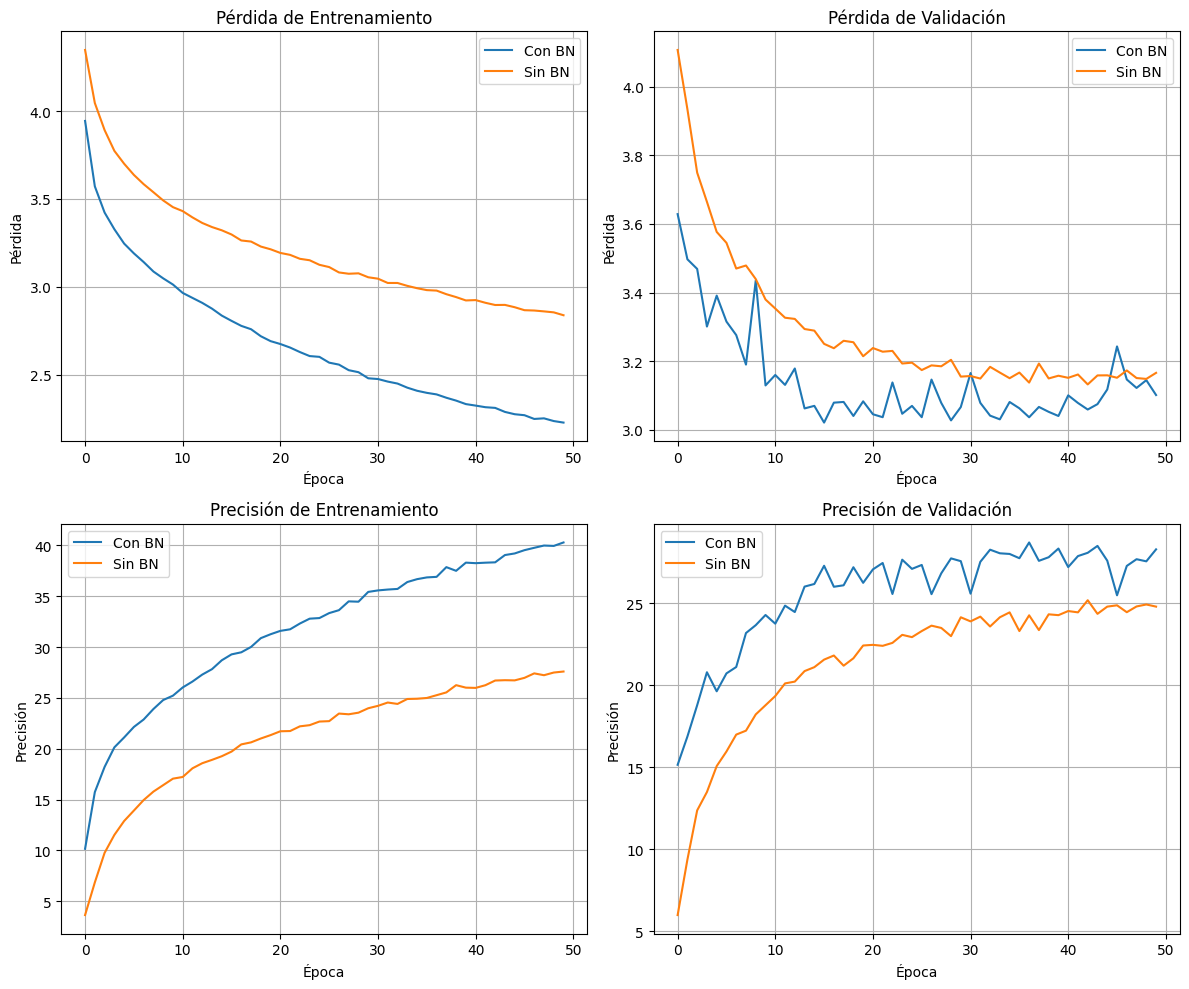

In [88]:
# Experimento 3: Con y sin Batch Normalization
resultados_bn = []

for use_bn in [True, False]:
    bn_label = "Con BN" if use_bn else "Sin BN"
    print(f"\nEntrenando modelo {bn_label}")
    
    # Crear modelo con o sin batch normalization
    modelo = MLPModel(input_shape, num_classes, use_batch_norm=use_bn)
    modelo.to(device)
    
    # Definir función de pérdida y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelo.parameters(), lr=0.001)
    
    # Early stopping
    patience = 60
    best_val_loss = float('inf')
    counter = 0
    
    # Historial para guardar métricas
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    # Entrenamiento por 50 épocas (reducido para experimentación)
    for epoch in range(50):
        # Modo entrenamiento
        modelo.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Poner a cero los gradientes
            optimizer.zero_grad()
            
            # Forward pass
            outputs = modelo(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass y optimización
            loss.backward()
            optimizer.step()
            
            # Estadísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_dataset)
        train_acc = 100 * correct / total
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        
        # Modo evaluación
        modelo.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = modelo(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = running_loss / len(val_dataset)
        val_acc = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch {epoch+1}/50, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping después de {epoch+1} épocas')
                break
    
    # Evaluación en el conjunto de prueba
    modelo.eval()
    all_preds = []
    
    with torch.no_grad():
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
    
    # Métricas
    y_test_original = y_test.flatten()
    accuracy = accuracy_score(y_test_original, all_preds)
    precision = precision_score(y_test_original, all_preds, average='weighted')
    recall = recall_score(y_test_original, all_preds, average='weighted')
    f1 = f1_score(y_test_original, all_preds, average='weighted')
    
    # Guardar historial para graficar
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    resultados_bn.append({
        'BatchNorm': bn_label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Val_Loss_Final': min(val_loss),
        'Épocas': len(train_loss),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    })

# Tabla comparativa de Batch Normalization
df_bn = pd.DataFrame([{k: v for k, v in res.items() if k not in ['train_loss', 'val_loss', 'train_acc', 'val_acc']} 
                     for res in resultados_bn])
print("\nComparación con y sin Batch Normalization:")
print(df_bn)

# Visualización de curvas de aprendizaje con y sin BN
plt.figure(figsize=(12, 10))

# Pérdida de entrenamiento
plt.subplot(2, 2, 1)
for res in resultados_bn:
    plt.plot(res['train_loss'], label=f"{res['BatchNorm']}")
plt.title('Pérdida de Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Pérdida de validación
plt.subplot(2, 2, 2)
for res in resultados_bn:
    plt.plot(res['val_loss'], label=f"{res['BatchNorm']}")
plt.title('Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Precisión de entrenamiento
plt.subplot(2, 2, 3)
for res in resultados_bn:
    plt.plot(res['train_acc'], label=f"{res['BatchNorm']}")
plt.title('Precisión de Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Precisión de validación
plt.subplot(2, 2, 4)
for res in resultados_bn:
    plt.plot(res['val_acc'], label=f"{res['BatchNorm']}")
plt.title('Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Mejores hiperparámetros encontrados:
Activación: elu
Tasa de Dropout: 0.2
Batch Normalization: Sí
Epoch 1/50, Loss: 3.9604, Accuracy: 9.92%, Val Loss: 3.6393, Val Accuracy: 14.98%
Epoch 2/50, Loss: 3.5714, Accuracy: 15.93%, Val Loss: 3.4772, Val Accuracy: 17.31%
Epoch 3/50, Loss: 3.4169, Accuracy: 18.09%, Val Loss: 3.4397, Val Accuracy: 18.32%
Epoch 4/50, Loss: 3.3246, Accuracy: 19.72%, Val Loss: 3.4343, Val Accuracy: 18.09%
Epoch 5/50, Loss: 3.2431, Accuracy: 21.39%, Val Loss: 3.3390, Val Accuracy: 20.39%
Epoch 6/50, Loss: 3.1956, Accuracy: 22.09%, Val Loss: 3.2464, Val Accuracy: 21.82%
Epoch 7/50, Loss: 3.1259, Accuracy: 23.18%, Val Loss: 3.2180, Val Accuracy: 22.50%
Epoch 8/50, Loss: 3.0944, Accuracy: 23.81%, Val Loss: 3.2734, Val Accuracy: 21.72%
Epoch 9/50, Loss: 3.0723, Accuracy: 24.26%, Val Loss: 3.1312, Val Accuracy: 24.72%
Epoch 10/50, Loss: 3.0168, Accuracy: 25.15%, Val Loss: 3.1602, Val Accuracy: 24.13%
Epoch 11/50, Loss: 2.9809, Accuracy: 25.82%, Val Loss: 3.1404, Val Accu

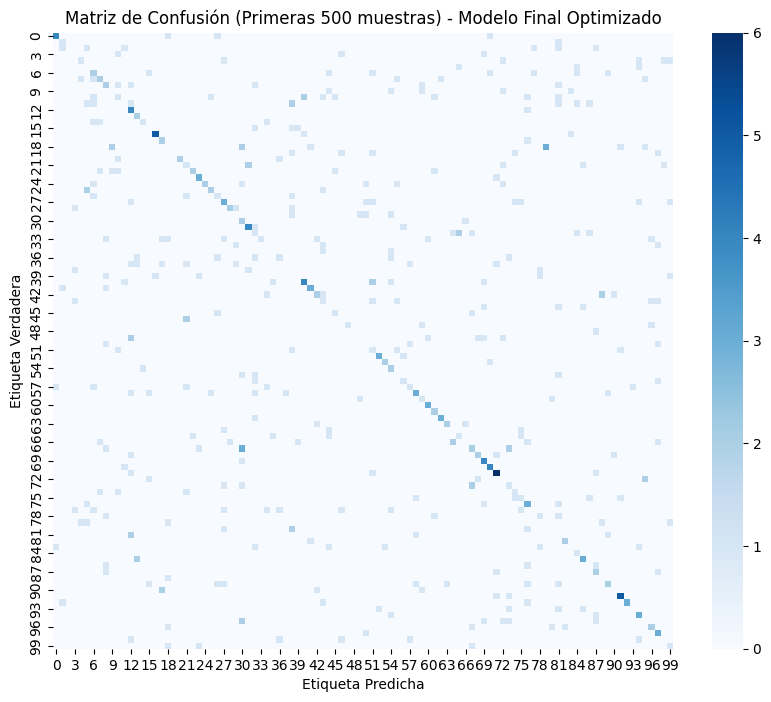


Informe de Clasificación - Modelo Final (primeras 10 clases):
              precision    recall  f1-score   support

     Clase 0       0.49      0.57      0.53       100
     Clase 1       0.31      0.41      0.35       100
     Clase 2       0.25      0.17      0.20       100
     Clase 3       0.22      0.14      0.17       100
     Clase 4       0.15      0.15      0.15       100
     Clase 5       0.18      0.27      0.21       100
     Clase 6       0.25      0.24      0.25       100
     Clase 7       0.42      0.31      0.36       100
     Clase 8       0.24      0.30      0.26       100
     Clase 9       0.41      0.33      0.37       100

   micro avg       0.29      0.29      0.29      1000
   macro avg       0.29      0.29      0.28      1000
weighted avg       0.29      0.29      0.28      1000



In [89]:
# 5. Modelo Final Optimizado
# --------------------------

# Basado en los experimentos, seleccionamos los mejores hiperparámetros
# (Estos valores deberían ser reemplazados por los mejores encontrados en tus experimentos)
mejor_activacion = df_activacion.loc[df_activacion['Accuracy'].idxmax(), 'Activación']
mejor_dropout = df_dropout.loc[df_dropout['Accuracy'].idxmax(), 'Tasa_Dropout']
mejor_bn = df_bn.loc[df_bn['Accuracy'].idxmax(), 'BatchNorm'] == "Con BN"

print("\nMejores hiperparámetros encontrados:")
print(f"Activación: {mejor_activacion}")
print(f"Tasa de Dropout: {mejor_dropout}")
print(f"Batch Normalization: {'Sí' if mejor_bn else 'No'}")

# Crear y entrenar el modelo final con los mejores hiperparámetros
modelo_final = MLPModel(
    input_shape,
    num_classes,
    activation=mejor_activacion,
    dropout_rate=mejor_dropout,
    use_batch_norm=mejor_bn
)
modelo_final.to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_final.parameters(), lr=0.001)

# Early stopping
patience = 60
best_val_loss = float('inf')
counter = 0

# Historial para guardar métricas
history_final = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

# Entrenamiento por 50 épocas para el modelo final
for epoch in range(50):
    # Modo entrenamiento
    modelo_final.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Poner a cero los gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = modelo_final(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_dataset)
    train_acc = 100 * correct / total
    history_final['loss'].append(train_loss)
    history_final['accuracy'].append(train_acc)
    
    # Modo evaluación
    modelo_final.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo_final(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_dataset)
    val_acc = 100 * correct / total
    history_final['val_loss'].append(val_loss)
    history_final['val_accuracy'].append(val_acc)
    
    print(f'Epoch {epoch+1}/50, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping después de {epoch+1} épocas')
            break

# Evaluación del modelo final
modelo_final.eval()
y_pred_final = []
y_test_original = y_test.flatten()

with torch.no_grad():
    test_loader = DataLoader(X_test_tensor, batch_size=batch_size)
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = modelo_final(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_final.extend(predicted.cpu().numpy())

# Métricas finales
accuracy_final = accuracy_score(y_test_original, y_pred_final)
precision_final = precision_score(y_test_original, y_pred_final, average='weighted')
recall_final = recall_score(y_test_original, y_pred_final, average='weighted')
f1_final = f1_score(y_test_original, y_pred_final, average='weighted')

print("\nMétricas del Modelo Final Optimizado:")
print(f"Accuracy: {accuracy_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print(f"Recall: {recall_final:.4f}")
print(f"F1-Score: {f1_final:.4f}")

# Matriz de confusión final (mostramos solo una parte debido a las 100 clases)
plt.figure(figsize=(10, 8))
cm_final = confusion_matrix(y_test_original[:500], y_pred_final[:500])  # Limitamos a 500 muestras para visualización
sns.heatmap(cm_final, annot=False, cmap='Blues')
plt.title('Matriz de Confusión (Primeras 500 muestras) - Modelo Final Optimizado')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("\nInforme de Clasificación - Modelo Final (primeras 10 clases):")
print(classification_report(y_test_original, y_pred_final, labels=range(10), target_names=[f"Clase {i}" for i in range(10)]))


Comparación Final de Modelos:
             Modelo  Accuracy  Precision  Recall  F1-Score
0              Base    0.2761   0.286111  0.2761  0.272717
1  Final Optimizado    0.2824   0.279232  0.2824  0.274658


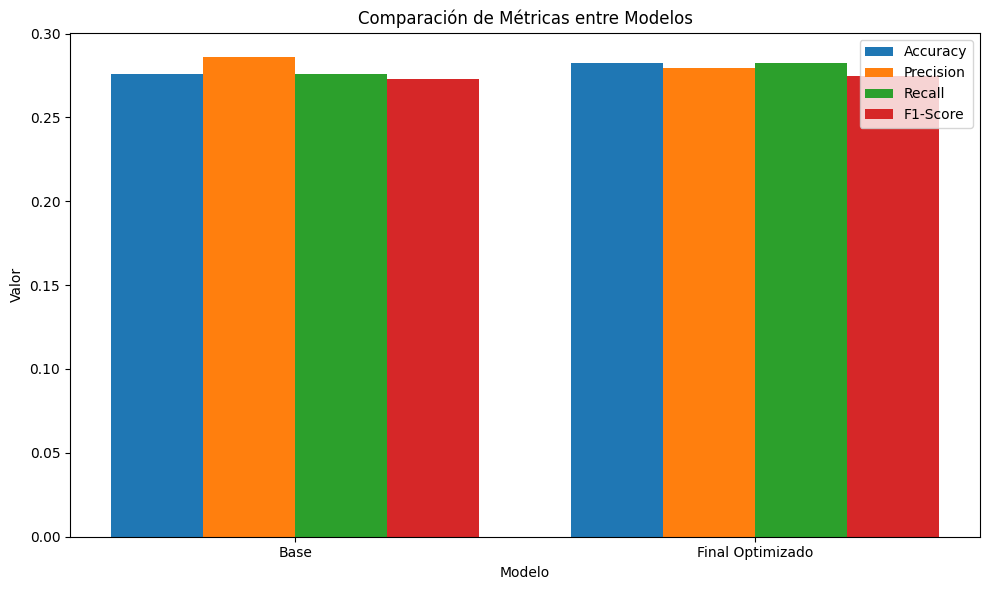

In [90]:
# 6. Comparación Final de Modelos
# ------------------------------

# Primero, necesitamos evaluar el modelo base si no lo hemos hecho ya
modelo_base.eval()
y_pred_base = []
y_test_original = y_test.flatten()

with torch.no_grad():
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = modelo_base(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_base.extend(predicted.cpu().numpy())

# Métricas del modelo base
accuracy_base = accuracy_score(y_test_original, y_pred_base)
precision_base = precision_score(y_test_original, y_pred_base, average='weighted')
recall_base = recall_score(y_test_original, y_pred_base, average='weighted')
f1_base = f1_score(y_test_original, y_pred_base, average='weighted')

# Crear tabla comparativa de todos los modelos
comparacion_final = pd.DataFrame([
    {
        'Modelo': 'Base',
        'Accuracy': accuracy_base,
        'Precision': precision_base,
        'Recall': recall_base,
        'F1-Score': f1_base
    },
    {
        'Modelo': 'Final Optimizado',
        'Accuracy': accuracy_final,
        'Precision': precision_final,
        'Recall': recall_final,
        'F1-Score': f1_final
    }
])

print("\nComparación Final de Modelos:")
print(comparacion_final)

# Visualización de comparación final
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(comparacion_final))

plt.bar(index, comparacion_final['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, comparacion_final['Precision'], bar_width, label='Precision')
plt.bar(index + 2*bar_width, comparacion_final['Recall'], bar_width, label='Recall')
plt.bar(index + 3*bar_width, comparacion_final['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('Comparación de Métricas entre Modelos')
plt.xticks(index + 1.5*bar_width, comparacion_final['Modelo'])
plt.legend()
plt.tight_layout()
plt.show()